# Fashion MNIST Image Classification
## ST1504 Deep Learning CA1 Part A

##### Name: Haja Amir Rahman
##### Class: DAAA/FT/2B/06
##### Admin Number: P2100803

## References:
- [ResNet50](https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691)
- [Flipping & cropping images](https://www.tensorflow.org/api_docs/python/tf/image/flip_left_right)

<h4><b>Notebook Contents:</b></h4>
1. Data Exploration/Background Research<br>
2. Data Augmentation/Feature Engineering<br>
3. Modelling & Evaluation<br>
4. Model Improvement<br>

<h3><b>1. Data Exploration/ Background Research</b></h3>

The Fashion MNIST Dataset is a dataset of Zalando's images, with 60000 examples for training and 10000 examples for testing. Each example is a 28x28 greyscale image, with 10 associated labels.

* Import all modules
* Load dataset
* Rescale test and train images

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:

import keras
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import pandas as pd
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras import backend as K
from keras import layers
from tensorflow.keras import Sequential
from matplotlib import pyplot

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 
'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## Normalization

In [4]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.fashion_mnist.load_data()
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.1, shuffle=False)
x_test = x_test/255
x_val = x_val/255
x_train = x_train/255

In [5]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(54000, 28, 28) (54000,)
(6000, 28, 28) (6000,)
(10000, 28, 28) (10000,)


* 54000 images of 28 pixels by 28 pixels for training and 54000 labels to pair with the images

* 6000 images of 28 x 28 for validation and 6000 labels

* 10000 images of 28 pixels by 28 pixels for testing and 10000 labels to pair with the images

- 28x28 image loaded

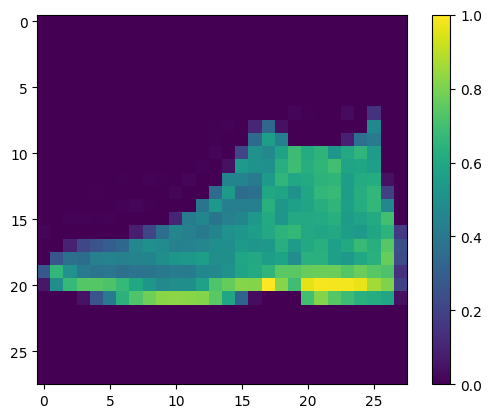

In [6]:
plt.figure()
plt.imshow(x_test[0])
plt.colorbar()
plt.grid(False)
plt.show()

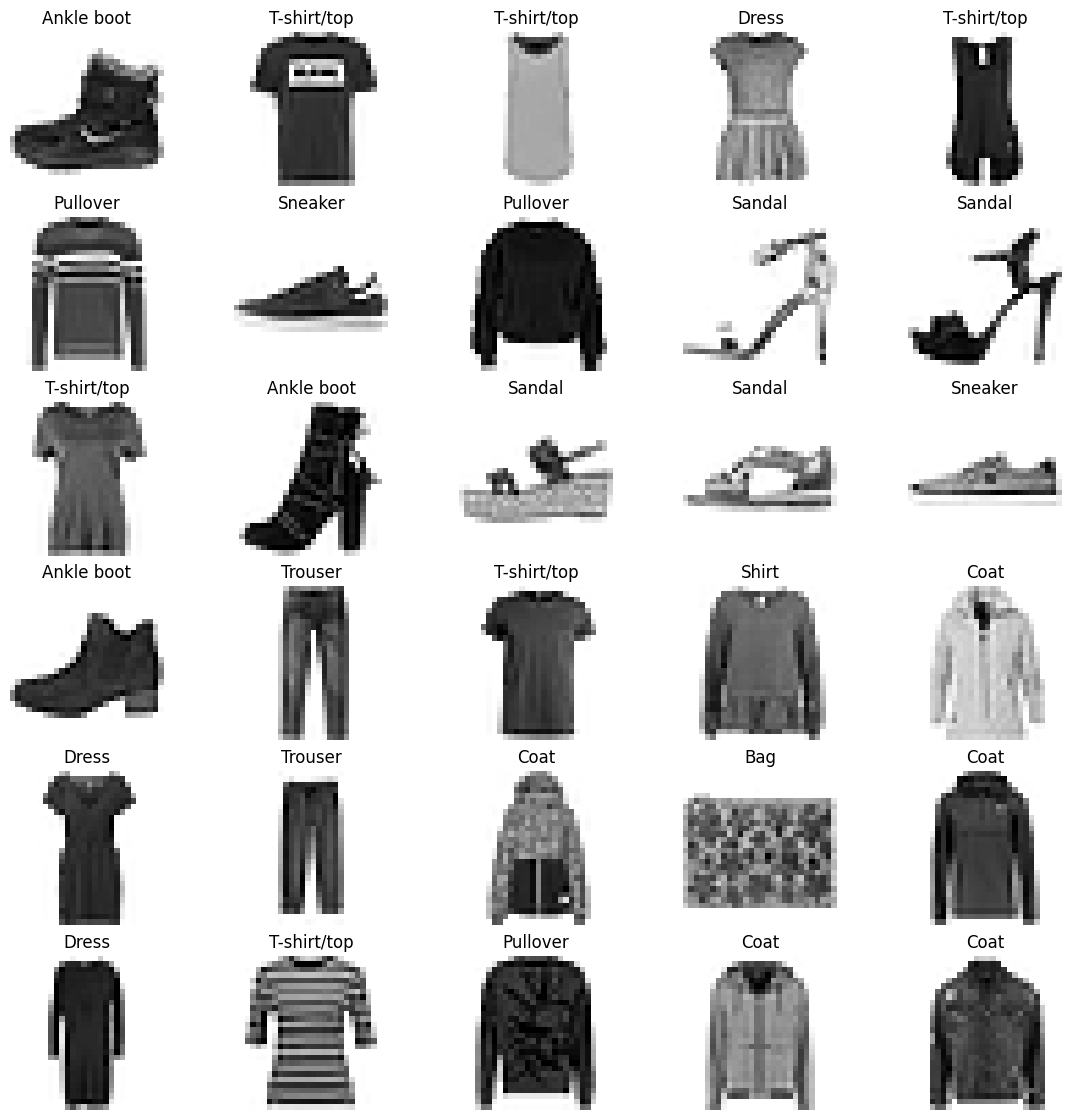

In [7]:
import matplotlib.pyplot as plt

NUM_ROW = 6               # CHANGE THIS
NUM_COL = 5               # CHANGE THIS
WIDTH = 14                # CHANGE THIS
HEIGHT = 14               # CHANGE THIS

fig, ax = plt.subplots(NUM_ROW, NUM_COL, figsize=(WIDTH, HEIGHT))
row_i = 0
col_i = 0

for i in range(30):        # CHANGE THIS

    img = x_train[i]
    label = y_train[i]
    
    ax[row_i, col_i].imshow(img, cmap=plt.cm.binary)
    ax[row_i, col_i].set_title(f"{class_names[label]}")
    ax[row_i, col_i].axis("off")

    col_i += 1
    if col_i > NUM_COL-1:
        row_i += 1
        col_i = 0
        
plt.show()

<h2>Objectives/Tasks</h2>

* Be able to accurately identify the test images fed to the model
* Get highest possible accuracy and loss (>95% accuracy)
* Use regularization methods, data augmentation and different model architecture to reduce overfitting while improving accuracy and loss

<h3><b>2. Data Augmentation</h3></b>

* Defined function to execute flipping and tilting on training images

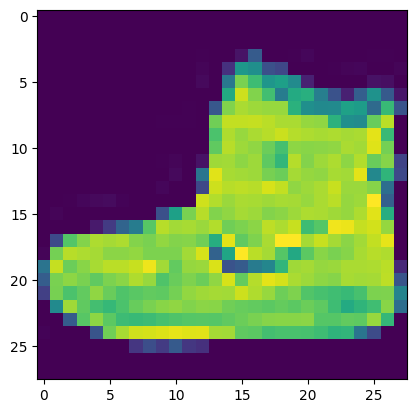

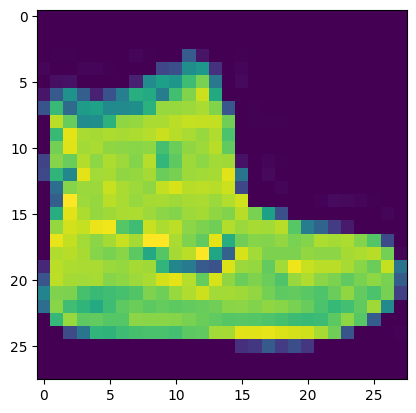

In [8]:
plt.imshow(x_train[0])
plt.show()
plt.imshow(tf.image.flip_left_right(x_train[0].reshape((*x_train[0].shape,1))))
plt.show()

(54000, 28, 28)


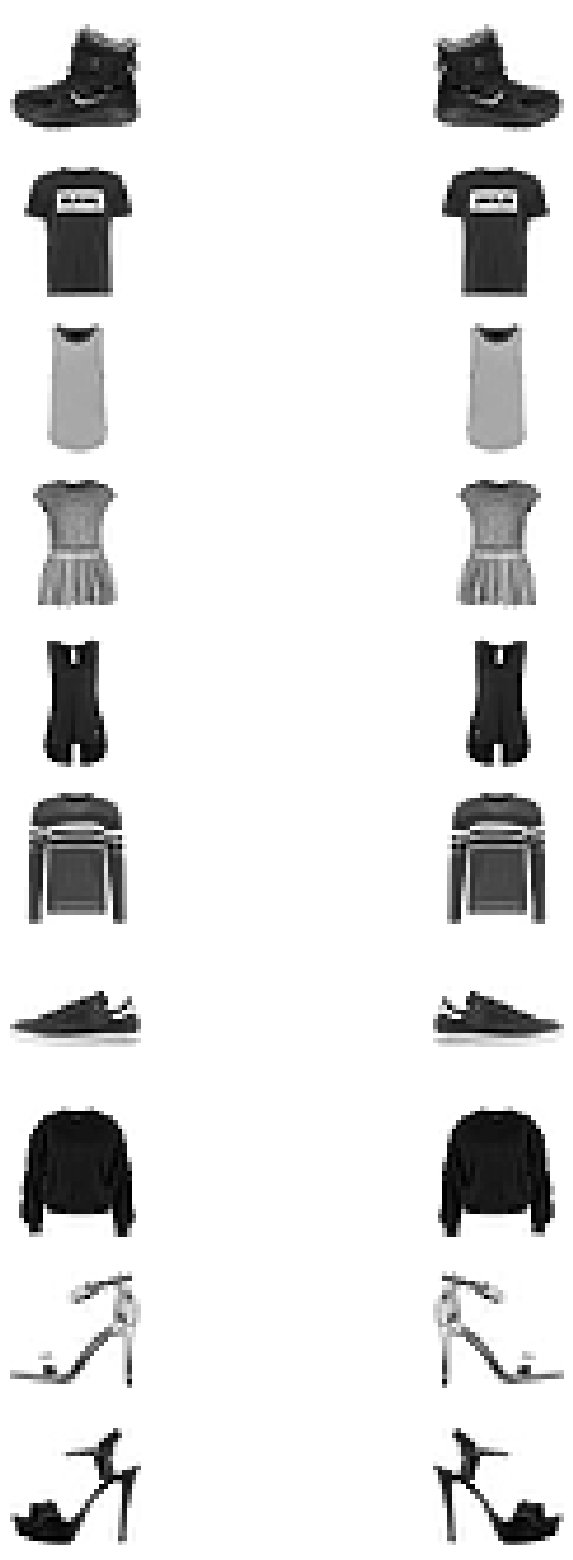

In [9]:
def flipall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.flip_left_right(images).numpy()
    images = images.reshape(images.shape[:3])

    return images
    
x_train_flipped = flipall(x_train)
print(x_train_flipped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_flipped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()
    

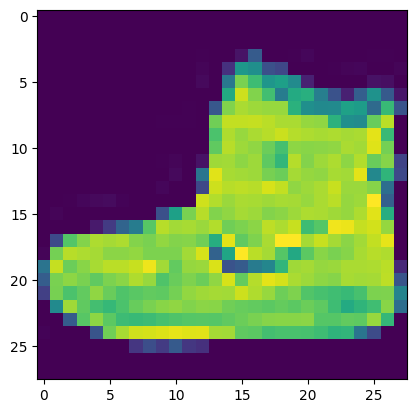

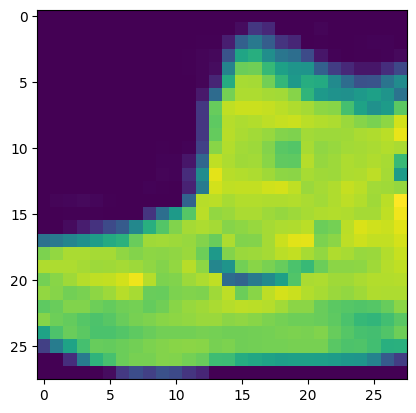



(54000, 28, 28)


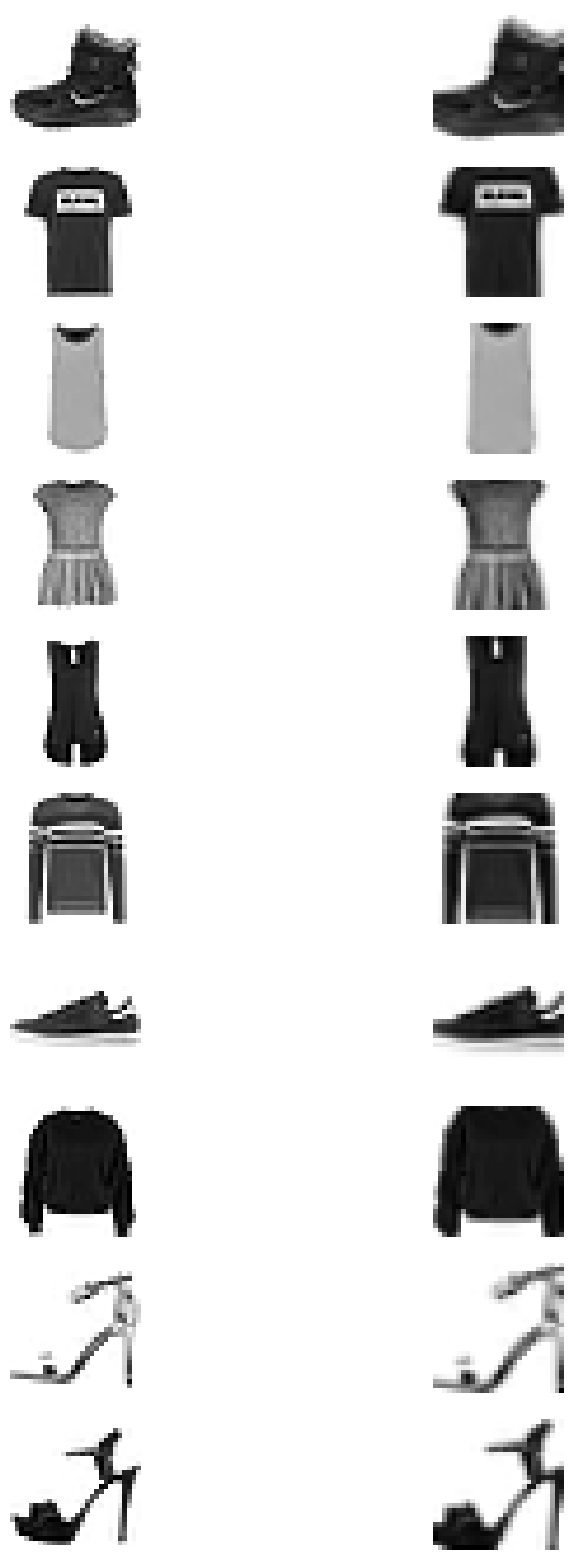

In [10]:
def cropall(images):
    images = images.reshape((*images.shape,1))
    images = tf.image.central_crop(images, 0.8)
    images = tf.image.resize(images, (28,28))
    images = images.numpy().reshape(images.shape[:3])

    return images

cropped_test = cropall(x_train[0])
plt.imshow(x_train[0])
plt.show()
plt.imshow(cropped_test)
plt.show()

print("\n"+"="*50+"\n")
    
x_train_cropped = cropall(x_train)
print(x_train_cropped.shape)

WIDTH = 10                # CHANGE THIS
HEIGHT = 20               # CHANGE THIS

fig, ax = plt.subplots(10, 2, figsize=(WIDTH, HEIGHT))

for i in range(10):        # CHANGE THIS
    
    img1 = x_train[i]    
    ax[i, 0].imshow(img1, cmap=plt.cm.binary)
    ax[i, 0].axis("off")
    
    img2 = x_train_cropped[i]    
    ax[i, 1].imshow(img2, cmap=plt.cm.binary)
    ax[i, 1].axis("off")
        
plt.show()

# Simple Baseline Model

In [11]:
model = Sequential([
    layers.Conv2D(32, (2,2), activation="relu", input_shape=(28, 28, 1)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(16, activation="relu"),
    layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(model.summary())

baseline_history = model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))
baseline_history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 flatten (Flatten)           (None, 23328)             0         
                                                                 
 dense (Dense)               (None, 16)                373264    
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 373,594
Trainable params: 373,594
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
1688/1688 [==============================] - 19s 7ms/step - loss: 0.5017 - accuracy: 0.8258 - val_loss: 0.3621 - val_accuracy: 0.8702
Epoch 2/5
1688/1688 [============

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.3191 - accuracy: 0.8884


[0.31911274790763855, 0.8884000182151794]

## Baseline Training and validation Accuracy

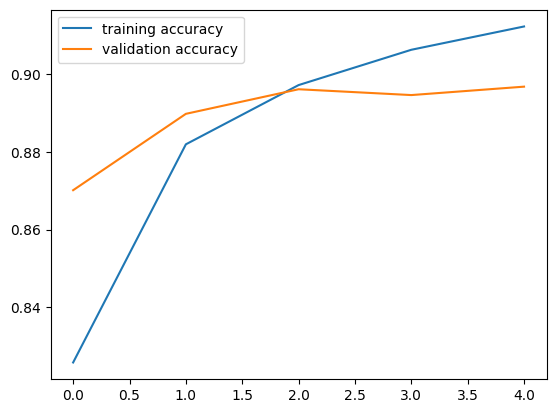

In [13]:
plt.plot(baseline_history.history['accuracy'], label='training accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='validation accuracy')
plt.legend()

plt.show()

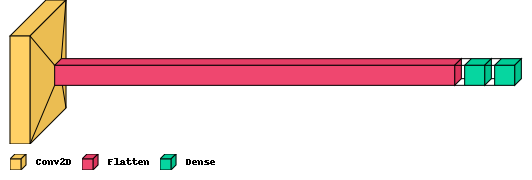

In [14]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(model, legend=True)

In [16]:
# model.save_weights("fashion-baseline-model.h5")

#### baseline model containing simple Conv2D layer gets testing accuracy of 90%

<h3><b>3. Modelling & Evaluation</h3></b>

<h3>Metrics Used</h3>

* Top 1 accuracy
* Top 3 accuracy
* Loss

# Own model

In [17]:
own_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),    
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),    
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(128, (3,3), activation="relu"),    
    # layers.MaxPooling2D((2, 2)),
    
    # layers.Conv2D(64, (3,3), activation="relu"),
    # layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.1),
    
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(own_model.summary())

history = own_model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val))
history

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)         

In [18]:
own_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.2644 - accuracy: 0.9170


[0.2644146680831909, 0.9169999957084656]

## Own model Training and validation Accuracy

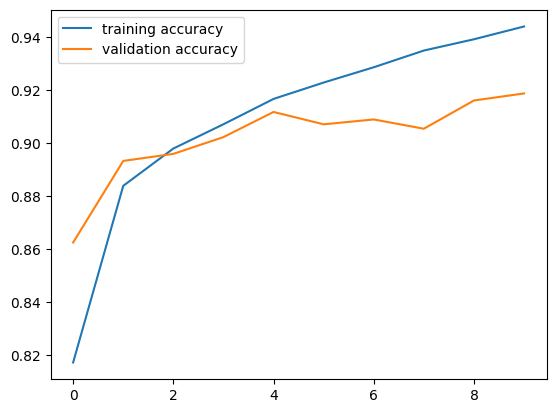

In [19]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()

plt.show()

## Own model Training and validation loss

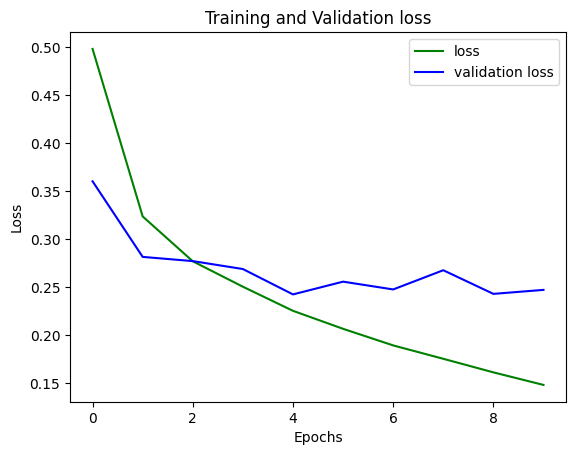

In [20]:
loss_val = history.history['val_loss']
loss = history.history['loss']
epoch = range(0,10)
plt.plot(epoch, loss, 'g', label='loss')
plt.plot(epoch, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

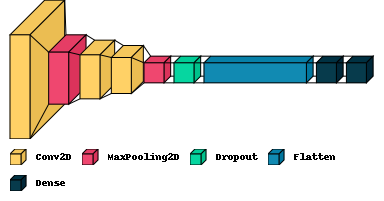

In [21]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_model, legend=True)

<h3><b>4. Model Improvement</h3></b>

In [22]:
x_train_augmented = list(x_train) + list(x_train_flipped) + list(x_train_cropped)
x_train_augmented = np.array(x_train_augmented)

y_train_augmented = np.array(list(y_train) * 3)

x_train_augmented.shape, y_train_augmented.shape

((162000, 28, 28), (162000,))

In [23]:
# x_test_augmented = list(x_test) + list(x_test_flipped) + list(x_test_cropped)
# x_test_augmented = np.array(x_test_augmented)

# y_test_augmented = np.array(list(y_train) * 3)

# x_test_augmented.shape, y_test_augmented.shape

In [24]:
baseline_augmented_model = Sequential([
    layers.Conv2D(64, (4,4), activation="relu", input_shape=(28, 28, 1)),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(), # 2d to 1d
    layers.Dense(128, activation="relu"),
    layers.Dense(10)
])

#copy pasted from documentation
baseline_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(baseline_augmented_model.summary())

baseline_augmented_history = baseline_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=5, validation_data=(x_val, y_val))
baseline_augmented_history

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 25, 25, 64)        1088      
                                                                 
 flatten_2 (Flatten)         (None, 40000)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               5120128   
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 5,122,506
Trainable params: 5,122,506
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
5063/5063 [==============================] - 44s 8ms/step - loss: 0.3651 - accuracy: 0.8661 - val_loss: 0.3050 - val_accuracy: 0.8898
Epoch 2/5
5063/5063 [======

In [25]:
baseline_augmented_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.3495 - accuracy: 0.9041


[0.34951072931289673, 0.9041000008583069]

In [26]:
# baseline_augmented_model.save_weights("fashion_baseline_augmented_model.h5")

In [27]:
own_augmented_model = Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1)),    
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.Conv2D(64, (3,3), activation="relu"),    
    layers.MaxPooling2D((2, 2)),

    # layers.Conv2D(128, (3,3), activation="relu"),    
    # layers.MaxPooling2D((2, 2)),
    
    # layers.Conv2D(64, (3,3), activation="relu"),
    # layers.GlobalAveragePooling2D(),
    
    layers.Dropout(0.1),
    
    layers.Flatten(), # 2d to 1d
    layers.Dense(64, activation="relu"),
    layers.Dense(10)
])

own_augmented_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print(own_augmented_model.summary())

history_augmented = own_augmented_model.fit(x_train_augmented, y_train_augmented, epochs=10, validation_data=(x_val, y_val))
history_augmented

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 64)         

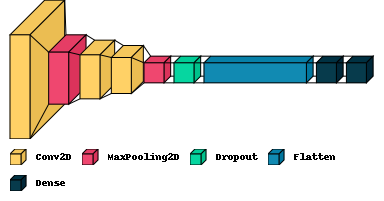

In [28]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(own_augmented_model, legend=True)

In [29]:
# plt.plot(history_augmented.history['accuracy'], label='training accuracy')
# plt.plot(history_augmented.history['val_accuracy'], label='validation accuracy')
# plt.legend()

# plt.show()

In [30]:
own_augmented_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.2621 - accuracy: 0.9169


[0.26213619112968445, 0.9168999791145325]

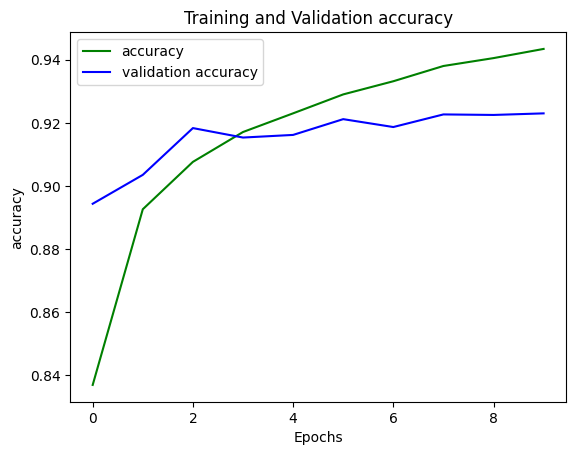

In [31]:
accuracy_val = history_augmented.history['val_accuracy']
accuracy = history_augmented.history['accuracy']
epoch = range(0,10)
plt.plot(epoch, accuracy, 'g', label='accuracy')
plt.plot(epoch, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

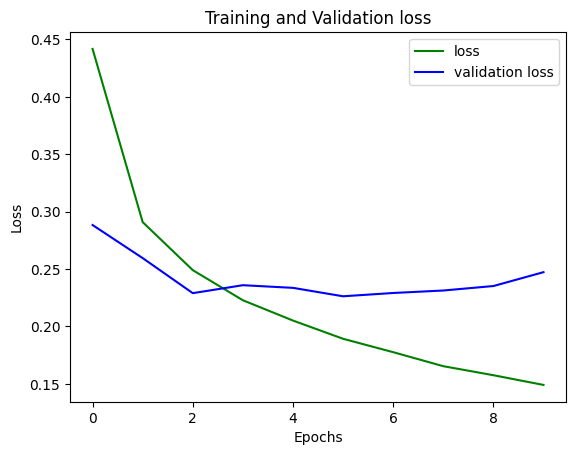

In [32]:
loss_val = history_augmented.history['val_loss']
loss = history_augmented.history['loss']
epoch = range(0,10)
plt.plot(epoch, loss, 'g', label='loss')
plt.plot(epoch, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# own_augmented_model.save_weights("fashion_augmented_model.h5")

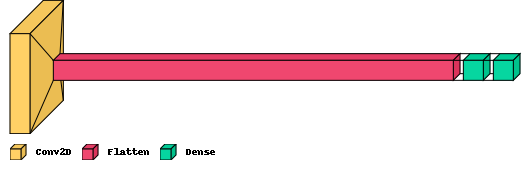

In [36]:
import visualkeras
from PIL import ImageFont
visualkeras.layered_view(baseline_augmented_model, legend=True)

In [ ]:
# # plot diagnostic learning curves
# def summarize_diagnostics(history_augmented):
# 	for i in range(len(histories)):
# 		# plot loss
# 		pyplot.subplot(211)
# 		pyplot.title('Cross Entropy Loss')
# 		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
# 		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
# 		# plot accuracy
# 		pyplot.subplot(212)
# 		pyplot.title('Classification Accuracy')
# 		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
# 		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
# 	pyplot.show()
 
# # summarize model performance
# def summarize_performance(accuracy):
# 	# print summary
# 	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
# 	# box and whisker plots of results
# 	pyplot.boxplot(scores)
# 	pyplot.show()
 
# # run the test harness for evaluating a model
# def run_test_harness():
# 	# load dataset
# 	trainX, trainY, testX, testY = load_dataset()
# 	# prepare pixel data
# 	trainX, testX = prep_pixels(trainX, testX)
# 	# evaluate model
# 	scores, histories = evaluate_model(trainX, trainY)
# 	# learning curves
# 	summarize_diagnostics(histories)
# 	# summarize estimated performance
# 	summarize_performance(scores)
 
# # entry point, run the test harness
# run_test_harness()

In [ ]:
# # resnet 50 but augmented data

# resnet50_augmented_model = resnet50()
# resnet50_augmented_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3), 
#                        metrics=['acc'])

# train_augmented_DataGen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, 
#                                                                 width_shift_range=0.1, 
#                                                                 height_shift_range = 0.1, 
#                                                                 horizontal_flip=True)
# batch_size=64

# train_labels_augmented_categorical = tf.keras.utils.to_categorical(
#     y_train_augmented, num_classes=10, dtype='uint8')

# train_augmented_set_conv = train_augmented_DataGen.flow(x_train_augmented.reshape((*x_train_augmented.shape,1)), train_labels_augmented_categorical, batch_size=batch_size)

# resnet_history = resnet50_model.fit(train_augmented_set_conv, epochs=100)